In [1]:
# Import Packages
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from loguru import logger
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from data import DATA_DIR

In [2]:
# Load CSV with explicit options
# df = pd.read_csv(
#     DATA_DIR / "data2 Sampled Scenarios.csv.arff.csv",
#     na_values=["inf", "-inf"],
# )
# df.info()

file_list = sorted(DATA_DIR.glob('data* Sampled Scenarios.csv.arff.csv'))
df = pd.concat((pd.read_csv(f, na_values=[np.inf, -np.inf]) for f in file_list), ignore_index=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78382 entries, 0 to 78381
Columns: 129 entries, R1-PA1:VH to marker
dtypes: float64(113), int64(16)
memory usage: 77.1 MB


In [3]:
df.head()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,154.194402,131760.0339,34.217040,131734.9606,-85.777512,131835.2537,157.798306,317.32963,33.621163,335.09130,...,0,0,0,0,0,0,0,0,0,37
1,154.068351,131885.4002,34.079530,131860.3269,-85.909292,131960.6200,156.721146,321.72427,33.317496,335.27441,...,0,0,0,0,0,0,0,0,0,37
2,154.051162,131885.4002,34.056611,131860.3269,-85.937940,131960.6200,156.629473,321.54116,33.197175,335.82374,...,0,0,0,0,0,0,0,0,0,37
3,154.016785,131910.4735,34.039423,131885.4002,-85.966588,131985.6933,156.216943,323.18915,33.059665,335.82374,...,0,0,0,0,0,0,0,0,0,37
4,-179.931666,134367.6539,60.097543,134342.5807,-59.908467,134442.8737,0.000000,0.00000,0.000000,0.00000,...,0,1,0,0,0,0,0,0,0,37


In [4]:
# Separate the label column "marker"
labels = df['marker']

# Continuous measurement columns (exclude columns with 'log' and 'marker')
continuous_cols = ~(df.columns.str.contains('log') & (df.columns != 'marker'))

# Log-related Boolean columns (include only columns with 'log')
log_cols = df.columns.str.contains('log')

<Axes: >

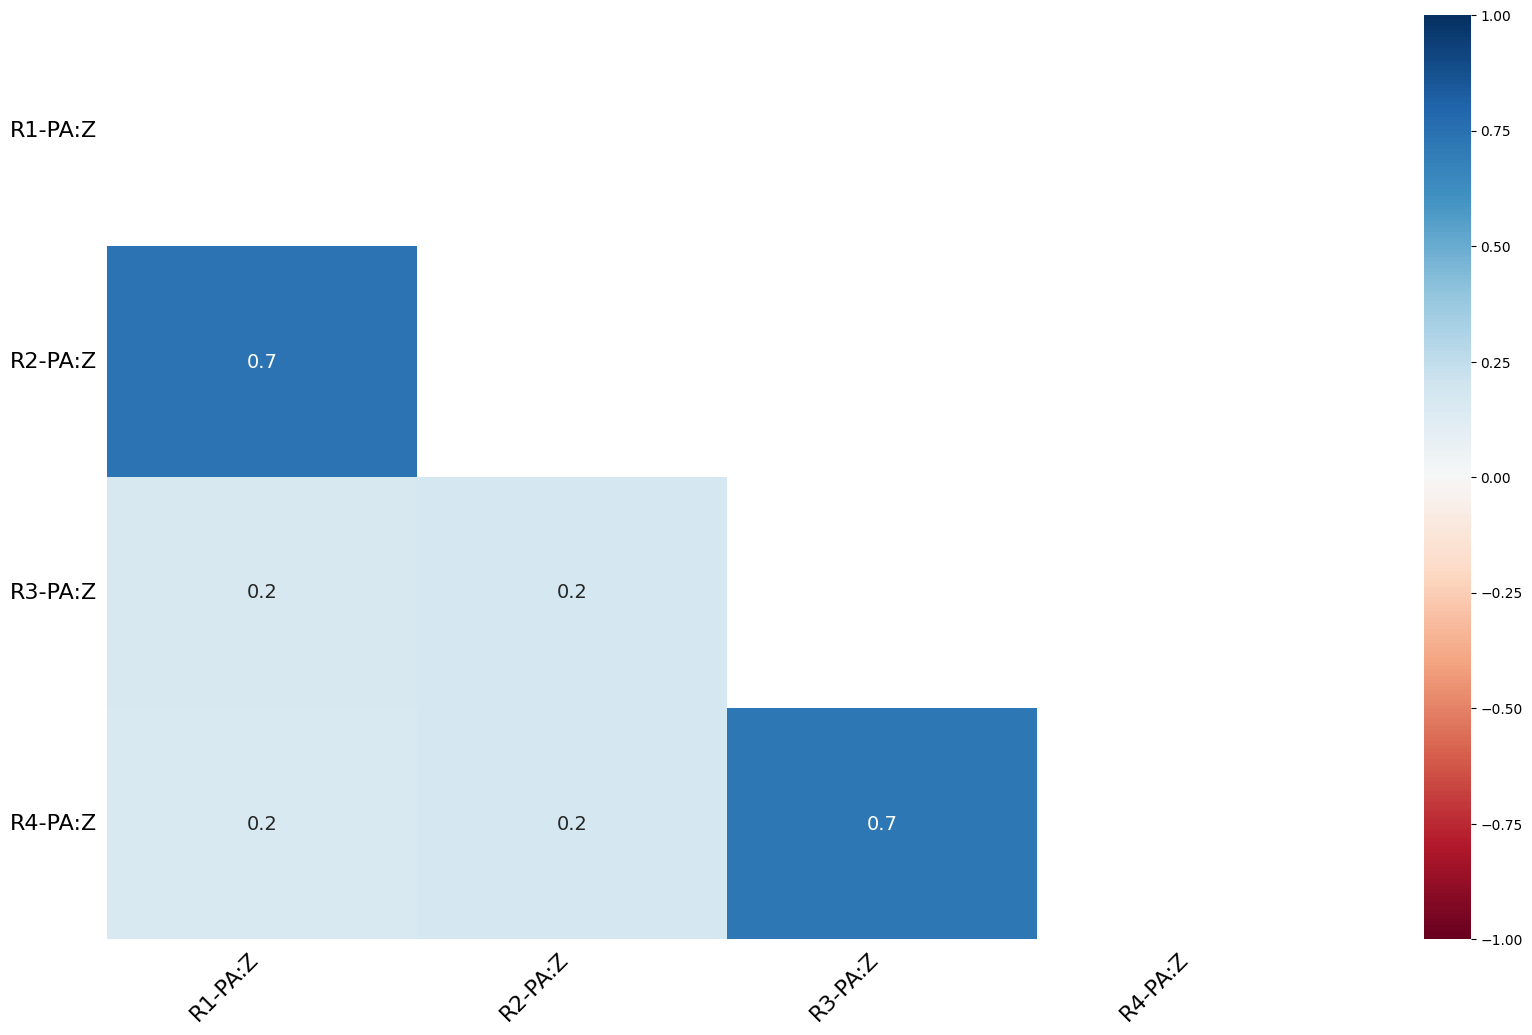

In [5]:
msno.heatmap(df.loc[:, continuous_cols])

In [6]:
# Count missing values in each column
missing_counts = df.isnull().sum()

# Calculate percentage of missing values
missing_percentages = 100 * missing_counts / len(df)

# Combine counts and percentages in a single dataframe
missing_table = pd.concat(
    [missing_counts, missing_percentages],
    axis=1,
    keys=["Missing Count", "Missing Percentage"],
)

# Filter to keep only columns with missing percentage above 0
missing_table = missing_table[missing_table["Missing Percentage"] > 0]

missing_table


,Missing Count,Missing Percentage
R1-PA:Z,2878,3.671761
R2-PA:Z,2607,3.326019
R3-PA:Z,2633,3.359190
R4-PA:Z,2789,3.558215


<Axes: title={'center': 'Percentage of Missing Values by Marker'}, xlabel='marker'>

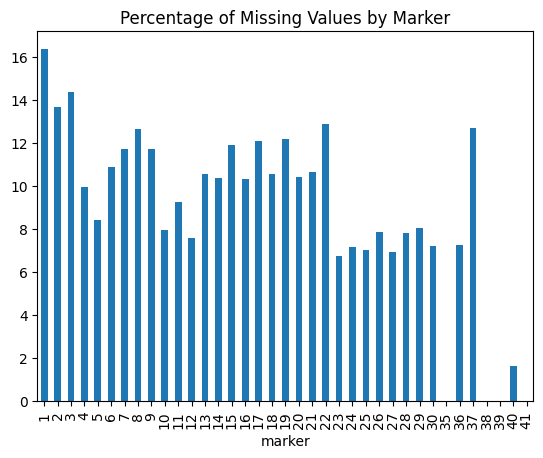

In [7]:
df.isnull().any(axis=1).groupby(df['marker']).mean().mul(100).plot(kind='bar', title='Percentage of Missing Values by Marker')

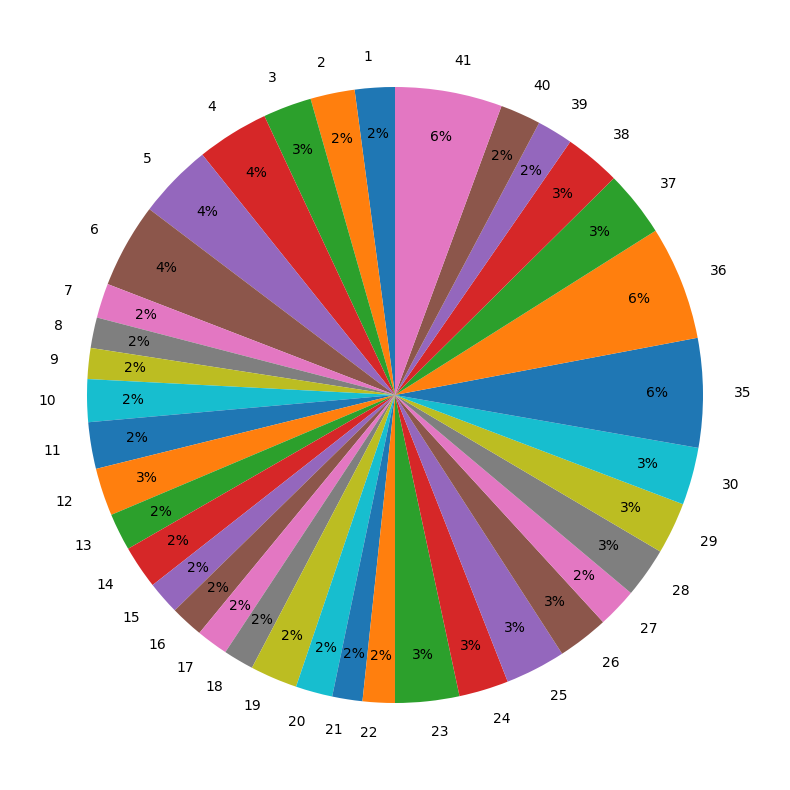

In [8]:
import matplotlib.pyplot as plt

# Increase the figure size for better spacing
plt.figure(figsize=(8, 8))

df['marker'].value_counts(normalize=True).sort_index().mul(100).plot(
    kind='pie',
    autopct='%.0f%%',      # integer percentages without decimals
    pctdistance=0.85,      # move percentages slightly away from center
    labeldistance=1.1,     # move labels a bit farther out
    startangle=90,         # rotate start for better label placement
    ylabel='',             # hide y label
    legend=False           # no legend
)

# plt.title('Percentage of Records by Marker', pad=20)
plt.tight_layout()         # adjust layout to fit labels
plt.show()


In [9]:
# Remove missing values
logger.info(f"Data loss: {(1 - len(df.dropna()) / len(df)) * 100:.2f}% of rows dropped")
df = df.dropna()

2025-09-16 19:53:21.528 | INFO     | __main__:<module>:2 - Data loss: 8.04% of rows dropped


In [10]:
# Split data into features and labels
X = df.drop(columns=['marker'])
y = df['marker']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

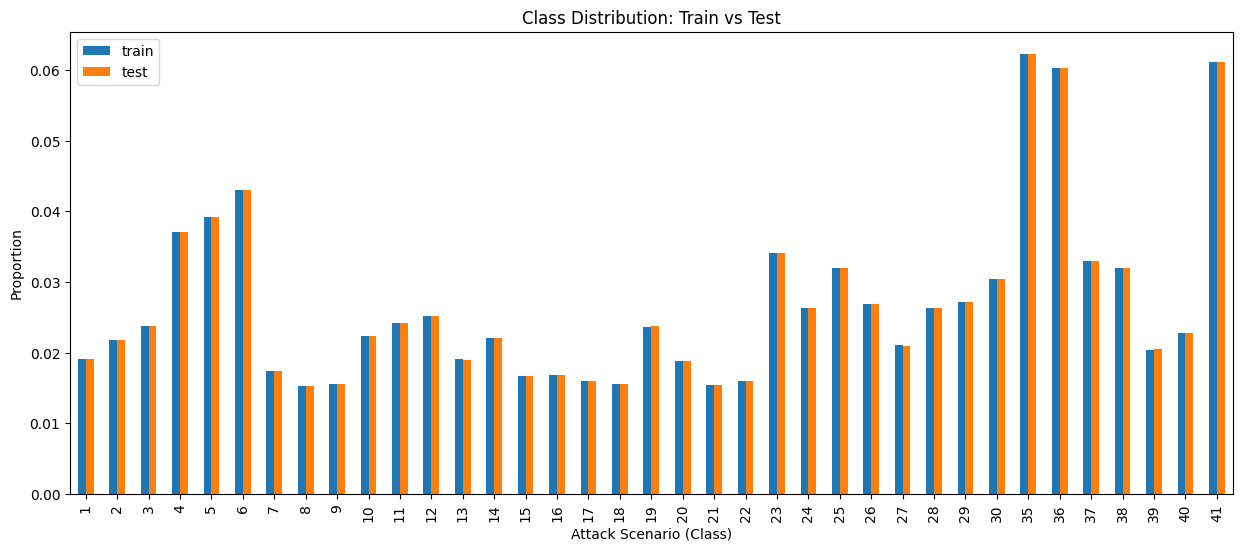

In [11]:
# Compute class distribution
train_dist = y_train.value_counts(normalize=True).sort_index()
test_dist = y_test.value_counts(normalize=True).sort_index()

# Combine into a DataFrame for comparison
dist_df = pd.DataFrame({'train': train_dist, 'test': test_dist})

# Plot side-by-side bar chart
dist_df.plot(kind='bar', figsize=(15, 6))
plt.title("Class Distribution: Train vs Test")
plt.ylabel("Proportion")
plt.xlabel("Attack Scenario (Class)")
plt.legend()
plt.show()


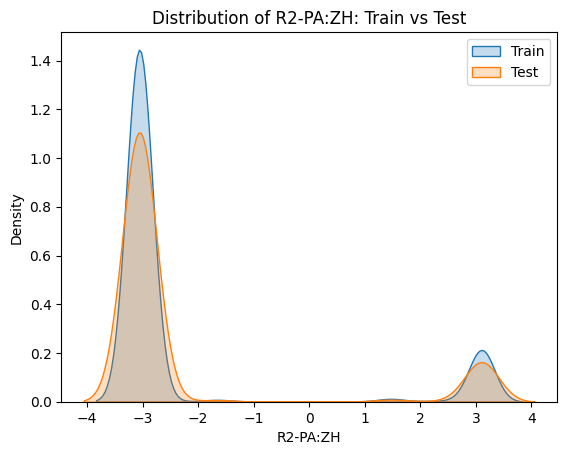

In [12]:
feature = "R2-PA:ZH"
sns.kdeplot(X_train[feature], label="Train", fill=True)
sns.kdeplot(X_test[feature], label="Test", fill=True)
plt.title(f"Distribution of {feature}: Train vs Test")
plt.legend()
plt.show()


In [13]:
# Scale features using RobustScaler
scaler = RobustScaler()

# Fit on train and transform both in one step
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

# Transform test set
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [14]:
# Calculate variance and sort descending
var_df = pd.DataFrame(X_train_scaled.var(), columns=["variance"]).sort_values("variance", ascending=False)

# Log them separately with clear headers and preserving table format
logger.info("Top 10 variance values:\n{}", var_df.head(10))
logger.info("Bottom 10 variance values:\n{}", var_df.tail(10))


2025-09-16 19:53:29.354 | INFO     | __main__:<module>:5 - Top 10 variance values:
              variance
R1:S      1.959508e+08
R3:S      1.959292e+08
R4:S      1.959287e+08
R2:S      1.959277e+08
R2-PM9:V  1.128528e+07
R3-PM9:V  1.125068e+07
R2-PM8:V  9.935772e+06
R3-PM8:V  9.889732e+06
R1-PM8:V  6.390220e+06
R4-PM8:V  5.910049e+06
2025-09-16 19:53:29.356 | INFO     | __main__:<module>:6 - Bottom 10 variance values:
                    variance
relay3_log          0.001022
relay2_log          0.001022
snort_log4          0.000087
snort_log3          0.000087
control_panel_log2  0.000052
control_panel_log1  0.000052
snort_log2          0.000052
snort_log1          0.000052
control_panel_log4  0.000017
control_panel_log3  0.000017


In [15]:
# Initialize the VarianceThreshold selector
selector = VarianceThreshold(threshold=0.1)

# Fit selector only on the training data
selector.fit(X_train)

# Transform both train and test sets using the fitted selector
X_train_selected = pd.DataFrame(selector.transform(X_train_scaled), 
                                columns=X_train.columns[selector.get_support()],
                                index=X_train.index)

X_test_selected = pd.DataFrame(selector.transform(X_test_scaled),
                               columns=X_test.columns[selector.get_support()],
                               index=X_test.index)

X_train.columns[selector.get_support()]

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'R4-PA9:VH', 'R4-PM9:V', 'R4-PA10:IH', 'R4-PM10:I', 'R4-PA11:IH',
       'R4-PM11:I', 'R4-PA12:IH', 'R4-PM12:I', 'R4-PA:Z', 'R4:S'],
      dtype='object', length=106)

In [16]:
# Instantiate the classifier with chosen hyperparameters (tune as needed)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on scaled training data
clf.fit(X_train_selected, y_train)

# Predict on the scaled test data
y_pred = clf.predict(X_test_selected)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)

logger.info(f"Test Accuracy: {accuracy*100:.2f}%")

2025-09-16 19:54:20.880 | INFO     | __main__:<module>:13 - Test Accuracy: 84.66%


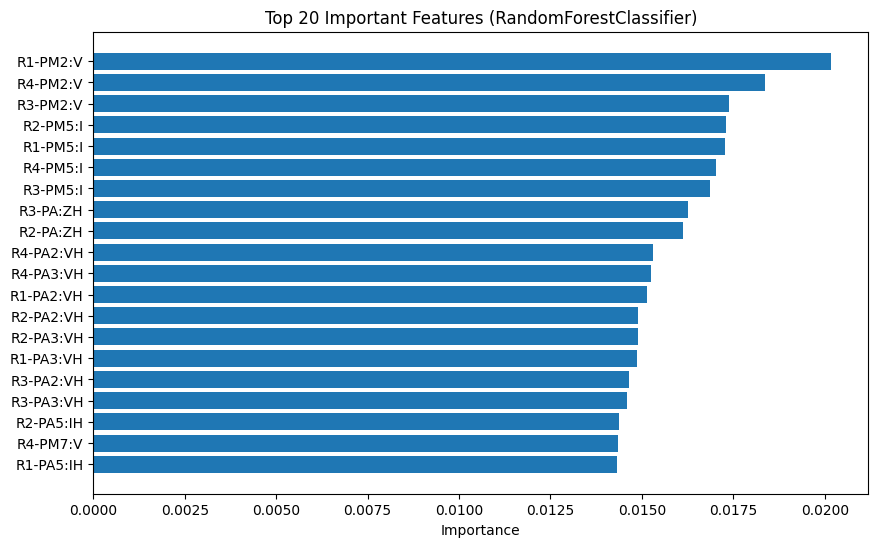

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# clf is the trained RandomForestClassifier
importances = clf.feature_importances_

# Create a DataFrame for easy handling
feat_importances = pd.DataFrame({
    'feature': X_train_selected.columns,
    'importance': importances
})

# Get top 20 features
top_10 = feat_importances.nlargest(20, 'importance')

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10['feature'], top_10['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Important Features (RandomForestClassifier)')
plt.gca().invert_yaxis()
plt.show()


In [28]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Encode target labels to zero-based integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize XGBoost classifier for multi-class classification
model = xgb.XGBClassifier(
    objective='multi:softprob',               # For probability outputs
    num_class=len(le.classes_),               # Number of classes detected by LabelEncoder
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss'                     # Suitable multi-class metric
)

# Train the model on scaled training data and encoded labels
model.fit(X_train_scaled, y_train_encoded)

# Predict class labels on scaled test data
y_pred_encoded = model.predict(X_test_scaled)

# Decode predicted labels back to original classes
y_pred = le.inverse_transform(y_pred_encoded)

# Detailed classification report with original class labels
logger.info(classification_report(y_test, y_pred))


/home/maede/anaconda3/envs/ids/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:16:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025-09-16 20:17:09.969 | INFO     | __main__:<module>:31 -               precision    recall  f1-score   support

           1       0.45      0.51      0.48       275
           2       0.56      0.43      0.49       315
           3       0.55      0.50      0.53       342
           4       0.64      0.66      0.65       535
           5       0.65      0.61      0.63       565
           6       0.63      0.63      0.63       621
           7       0.56      0.48      0.52       251
           8       0.61      0.43      0.50       220
           9       0.66      0.48      0.56       224
          10       0.76      0.61      0.68       323
          11       0.77      0.67      0.72       348
          12       0.69      0.71      0.70   

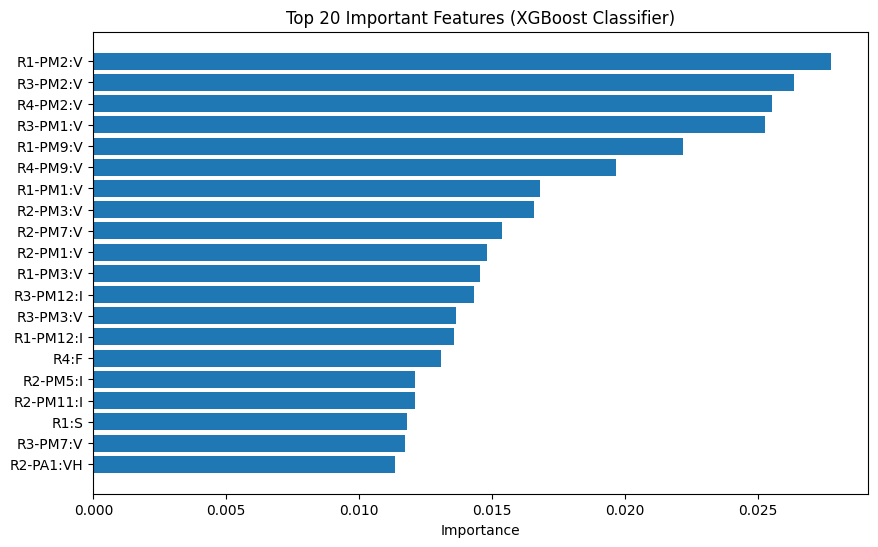

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances from the trained XGBoost model
importances = model.feature_importances_

# Create a DataFrame for easier handling and sorting
feat_importances = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': importances
})

# Get the top 20 features by importance
top_20 = feat_importances.nlargest(20, 'importance')

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_20['feature'], top_20['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Important Features (XGBoost Classifier)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Create the SVM classifier object (example with linear kernel)
svm_clf = SVC(kernel='linear', random_state=42)

# Step 2: Train the classifier on scaled training data
svm_clf.fit(X_train_scaled, y_train)

# Step 3: Make predictions on scaled test data
y_pred = svm_clf.predict(X_test_scaled)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
logger.info("Accuracy:", accuracy)
logger.info("Classification Report:\n", classification_report(y_test, y_pred))
